# Importing the required packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.contrib.parmest import parmest # import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
import idaes

# Data

Table S1. Initial guesses for the kinetic parameter values used to test the sensitivity of MBDoE to the initial parameter
estimates (both Ramp F and Ramp FT scenarios).

In [3]:
theta_init = {
    "Parameter Set": ["Factorial Estimates", "A", "B", "C", "D"],
    "KP1": [9.12, 8.5, 9.5, 8.5, 9.5],
    "KP2": [7.98, 6.0, 11, 10, 7.0],
    "k0 (s^-1)": ["1.17E+07", "3.95E+04", "1.17E+11", "1.32E+10", "3.49E+05"],
    "EA (J/mol)": [79800, 60000, 110000, 100000, 70000],
    "k at 100°C (*10^5 s^-1)": [0.78, 1.58, 0.47, 1.33, 0.56],
    "k at 120°C (*10^5 s^-1)": [2.88, 4.21, 2.84, 6.85, 1.75],
    "k at 140°C (*10^5 s^-1)": [9.40, 10.25, 14.50, 30.11, 4.94]
}

theta_init = pd.DataFrame(theta_init)
theta_init.columns = ['Parameter Set', 'KP1', 'KP2', 'k0', 'EA',
       'k@100C', 'k@120C', 'k@140C']
theta_init


,Parameter Set,KP1,KP2,k0,EA,k@100C,k@120C,k@140C
0,Factorial Estimates,9.12,7.98,1.17E+07,79800,0.78,2.88,9.40
1,A,8.50,6.00,3.95E+04,60000,1.58,4.21,10.25
2,B,9.50,11.00,1.17E+11,110000,0.47,2.84,14.50
3,C,8.50,10.00,1.32E+10,100000,1.33,6.85,30.11
4,D,9.50,7.00,3.49E+05,70000,0.56,1.75,4.94


Table S2. Time each sample was measured, left and entered the reactor and corresponding reaction time,
along with conversion and outlet concentrations of benzoic acid and ethyl benzoate for the first MBDoE Ramp
F experiment. The initial flowrate was 29.8 µL/min, the flowrate was ramped down at a rate of 0.253 µL/min2
, while the temperature was held constant at 119 oC and the feed concentration was 1.56 M.

In [14]:
data_FR1 = {
    "tM,i Time the sample was measured (s)": [408, 828, 1248, 1667, 2084, 2504, 2923, 3342, 3763, 4182, 4603, 5024, 5444, 5864],
    "tIn,i Time the sample entered the reactor (s)": [110, 511, 910, 1304, 1693, 2080, 2460, 2833, 3198, 3549, 3885, 4199, 4481, 4722],
    "tL,i Time the sample left the reactor (s)": [314, 728, 1141, 1552, 1959, 2368, 2774, 3177, 3578, 3972, 4360, 4736, 5094, 5422],
    "τi Sample reaction time (s)": [204, 217, 231, 248, 267, 288, 314, 344, 380, 422, 474, 537, 613, 700],
    "X Conversion (%)": [5.8, 5.8, 6.4, 7.1, 7.1, 7.7, 8.3, 9.0, 9.6, 10.9, 12.2, 13.5, 14.7, 16.7],
    "Outlet Concentration Benzoic Acid (M)": [1.47, 1.47, 1.46, 1.45, 1.45, 1.44, 1.43, 1.42, 1.41, 1.39, 1.37, 1.35, 1.33, 1.30],
    "Outlet Concentration Ethyl Benzoate (M)": [0.09, 0.09, 0.10, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.18, 0.20, 0.23, 0.25]
}

ramp_F1 = pd.DataFrame(data_FR1)
ramp_F1.columns = columns=["t_m (s)", "t_in (s)", "t_L (s)", "tau_(s)", "X(%)", "C_BA(M)", "C_EB(M)"]
# adding the temperature to the data
ramp_F1["T(C)"] = 119
# adding the feed concentration to the data
ramp_F1["C_F(M)"] = 1.56

# adding the ramped flowrate to the data
initial_flowrate = 29.8  # µL/min
ramp_rate = 0.253  # µL/min^2

# Calculate the time elapsed since the start of the ramp
time_elapsed = ramp_F1['t_m (s)']

# Calculate the flowrate at each time point
ramp_F1['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)
ramp_F1

,t_m (s),t_in (s),t_L (s),tau_(s),X(%),C_BA(M),C_EB(M),T(C),C_F(M),F(µL/min)
0,408,110,314,204,5.8,1.47,0.09,119,1.56,28.079600
1,828,511,728,217,5.8,1.47,0.09,119,1.56,26.308600
2,1248,910,1141,231,6.4,1.46,0.10,119,1.56,24.537600
3,1667,1304,1552,248,7.1,1.45,0.10,119,1.56,22.770817
4,2084,1693,1959,267,7.1,1.45,0.11,119,1.56,21.012467
5,2504,2080,2368,288,7.7,1.44,0.12,119,1.56,19.241467
6,2923,2460,2774,314,8.3,1.43,0.13,119,1.56,17.474683
7,3342,2833,3177,344,9.0,1.42,0.14,119,1.56,15.707900
8,3763,3198,3578,380,9.6,1.41,0.15,119,1.56,13.932683
9,4182,3549,3972,422,10.9,1.39,0.17,119,1.56,12.165900


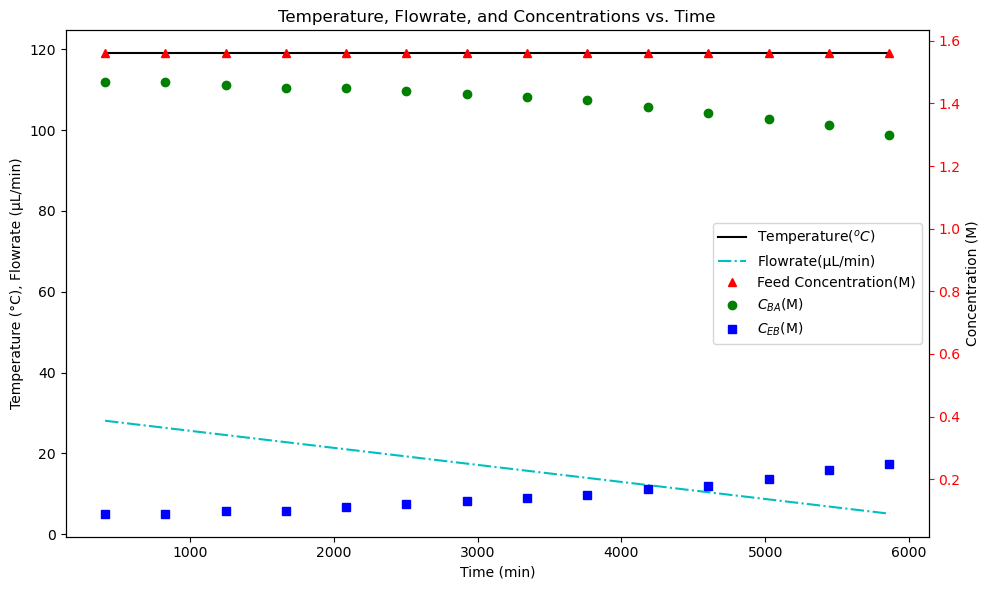

In [28]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
# plotting on left y-axis
ax.plot(ramp_F1["t_m (s)"], ramp_F1["T(C)"], "-k", label="Temperature($^oC$)")
ax.plot(ramp_F1["t_m (s)"], ramp_F1["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
ax.set_xlabel('Time (min)')
ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
ax.tick_params('y', colors='k')

# plotting on right y-axis
ax2 = ax.twinx()
ax2.plot(ramp_F1["t_m (s)"], ramp_F1["C_F(M)"], "^r", label="Feed Concentration(M)")
ax2.plot(ramp_F1["t_m (s)"], ramp_F1["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
ax2.plot(ramp_F1["t_m (s)"], ramp_F1["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
ax2.set_ylabel('Concentration (M)')
ax2.tick_params('y', colors='r')

# Customize the plot
plt.title('Temperature, Flowrate, and Concentrations vs. Time')
fig.tight_layout()

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

Table S3. Time each sample was measured, left and entered the reactor and corresponding reaction time,
along with conversion and outlet concentrations of benzoic acid and ethyl benzoate for the second MBDoE
Ramp F experiment. The initial flowrate was 9.13 µL/min, the flowrate was ramped down at a rate of 0.043
µL/min2, while the temperature was held constant at 139.4 oC and the feed concentration was 1.55 M.

In [5]:
data_FR2 = {
    "Time the sample was measured (t_M,i)": [152, 571, 991, 1411, 1830, 2251, 2670, 3090, 3510, 3931, 4350, 4770, 5190, 5610],
    "Time the sample entered the reactor (t_In,i)": [None, None, 17, 404, 787, 1170, 1549, 1925, 2298, 2668, 3033, 3393, 3749, 4098],
    "Time the sample left the reactor (t_L,i)": [None, 271, 680, 1089, 1496, 1904, 2309, 2714, 3117, 3520, 3920, 4318, 4715, 5109],
    "Sample reaction time (τ_i)": [623, 643, 663, 685, 709, 734, 760, 789, 819, 852, 887, 925, 966, 1010],
    "Conversion (X)": [44.9, 45.5, 46.2, 47.4, 48.1, 48.7, 50.0, 51.3, 51.9, 53.8, 55.1, 56.4, 57.7, 59.0],
    "Outlet Concentration Benzoic Acid (M)": [0.86, 0.85, 0.84, 0.82, 0.81, 0.80, 0.78, 0.76, 0.75, 0.72, 0.70, 0.68, 0.66, 0.64],
    "Outlet Concentration Ethyl Benzoate (M)": [0.70, 0.70, 0.72, 0.73, 0.74, 0.76, 0.78, 0.79, 0.81, 0.83, 0.86, 0.87, 0.90, 0.92]
}

ramp_F2 = pd.DataFrame(data_FR2)
ramp_F2.columns = columns=["t_m (s)", "t_in (s)", "t_L (s)", "tau_(s)", "X(%)", "C_BA(M)", "C_EB(M)"]
ramp_F2


,t_m (s),t_in (s),t_L (s),tau_(s),X(%),C_BA(M),C_EB(M)
0,152,NaN,NaN,623,44.9,0.86,0.70
1,571,NaN,271.0,643,45.5,0.85,0.70
2,991,17.0,680.0,663,46.2,0.84,0.72
3,1411,404.0,1089.0,685,47.4,0.82,0.73
4,1830,787.0,1496.0,709,48.1,0.81,0.74
5,2251,1170.0,1904.0,734,48.7,0.80,0.76
6,2670,1549.0,2309.0,760,50.0,0.78,0.78
7,3090,1925.0,2714.0,789,51.3,0.76,0.79
8,3510,2298.0,3117.0,819,51.9,0.75,0.81
9,3931,2668.0,3520.0,852,53.8,0.72,0.83


Table S4. Time each sample was measured, left and entered the reactor, corresponding reaction time, and the
reactor temperature at the time the samples entered and left the reactor, along with conversion and outlet
concentrations of benzoic acid and ethyl benzoate for the MBDoE Ramp FT experiment. The initial flowrate
was 10.1 µL/min, the flowrate was ramped down at a rate of 0.05 µL/min2
, while the initial temperature was
139.2 oC, and it was ramped down at a rate of 0.537 oC/min. The feed concentration of benzoic acid was held
constant at 1.56 M.

In [6]:
data_FT = {
    "Time the sample was measured (s)": [419, 840, 1260, 1679, 2099, 2519, 2939, 3359, 3779, 4199, 4619, 5038, 5457, 5876],
    "Time the sample entered the reactor (s)": ["NA", "NA", 354, 739, 1124, 1505, 1883, 2258, 2629, 2996, 3358, 3714, 4064, 4407],
    "Time the sample left the reactor (s)": ["NA", 150, 561, 971, 1379, 1786, 2193, 2599, 3003, 3406, 3807, 4206, 4602, 4995],
    "Sample reaction time (s)": [577, 596, 617, 639, 663, 688, 716, 745, 777, 811, 848, 888, 931, 979],
    "Reactor temperature at time tini (°C)": [139.2, 139.2, 136.0, 132.6, 129.1, 125.7, 122.3, 119.0, 115.7, 112.4, 109.1, 106.0, 102.8, 99.8],
    "Reactor temperature at time tLi (°C)": [139.2, 134.2, 130.5, 126.9, 123.2, 119.6, 115.9, 112.3, 108.7, 105.1, 101.6, 98.0, 94.5, 91.0],
    "X Conversion (%)": [41.5, 39.6, 35.1, 31.2, 26.7, 23.5, 19.7, 17.1, 14.5, 12.6, 10.0, 8.7, 7.5, 6.2],
    "Outlet Conc. Benzoic Acid (M)": [0.91, 0.94, 1.01, 1.07, 1.14, 1.19, 1.25, 1.29, 1.33, 1.36, 1.40, 1.42, 1.44, 1.46],
    "Outlet Conc. Ethyl Benzoate (M)": [0.64, 0.62, 0.55, 0.49, 0.42, 0.37, 0.31, 0.27, 0.22, 0.19, 0.16, 0.13, 0.11, 0.09]
}

ramp_FT = pd.DataFrame(data_FR2)
ramp_FT.columns = columns=["t_m (s)", "t_in (s)", "t_L (s)", "tau_(s)", "X(%)", "C_BA(M)", "C_EB(M)"]
ramp_FT

,t_m (s),t_in (s),t_L (s),tau_(s),X(%),C_BA(M),C_EB(M)
0,152,NaN,NaN,623,44.9,0.86,0.70
1,571,NaN,271.0,643,45.5,0.85,0.70
2,991,17.0,680.0,663,46.2,0.84,0.72
3,1411,404.0,1089.0,685,47.4,0.82,0.73
4,1830,787.0,1496.0,709,48.1,0.81,0.74
5,2251,1170.0,1904.0,734,48.7,0.80,0.76
6,2670,1549.0,2309.0,760,50.0,0.78,0.78
7,3090,1925.0,2714.0,789,51.3,0.76,0.79
8,3510,2298.0,3117.0,819,51.9,0.75,0.81
9,3931,2668.0,3520.0,852,53.8,0.72,0.83
